# Quara RNN Baseline

This kernel is based on:
1. Kernel ["LSTM is all you need! well, maybe embeddings also"](https://www.kaggle.com/mihaskalic/lstm-is-all-you-need-well-maybe-embeddings-also)
2. [Practical Text Classification With Python and Keras](https://mlwhiz.com/blog/2018/12/17/text_classification/)

The kernel is organised as follows:
1. Utils
2. Setup and Data Preprocessing
3. Neural Network
4. Prediction and Submission

In [8]:
import os
print(os.listdir("data/"))

['embeddings', '.DS_Store', 'test.csv', 'train.csv']


In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm

seed = 123

## 1. Utils

#### 1.1 Dataset Loader

In [10]:
class DataLoader:
    
    def load(self, file_names):
        self.train_df = pd.read_csv(file_names['train'])
        self.test_df = pd.read_csv(file_names['test'])
        ## fill up the missing values
        self.train_df['question_text'].fillna('_na_', inplace=True)
        self.test_df['question_text'].fillna('_na_', inplace=True)
        print('Train shape : ', self.train_df.shape)
        print('Test shape : ', self.test_df.shape)

#### 1.2 Load embeddings & transform text to vectors

In [11]:
class Embeddings:
    
    def __init__(self):
        self.embed_len = 300
        self.punctuation = set('!#$%&()*+,.:;<>?@[\\]')
    
    ## load embeddings
    def load(self, embedding_file_name):
        self.embeddings_index = {}
        f = open(embedding_file_name)
        for line in tqdm(f):
            values = line.split(' ');
            word = values[0]
            coef = np.asarray(values[1:], dtype='float32')
            self.embeddings_index[word] = coef
        self.embed_len = len(coef) # length of embeddings
        f.close()
        
    def text_to_vec(self, text, max_text_len=30):
        if text[-1] in self.punctuation:
            text = text[:-1].split() + [text[-1]]
        else:
            text = text.split()
        text = text[:max_text_len]
        empyt_emb = np.zeros(self.embed_len)
        embeds = [self.embeddings_index.get(word, empyt_emb) for word in text]
        embeds+= [empyt_emb] * (max_text_len - len(embeds))
        
        return np.array(embeds)
    
    def sequences_to_vec(self, text_sequences, max_text_len=30):
        vectors = [self.text_to_vec(text, max_text_len) for text in text_sequences]
        
        return np.array(vectors)

#### 1.3 Batch Generators

In [12]:
# generator for training NNet (used via fit_generator method in keras)
def batch_gen(train_df, batch_size, emb, max_text_len=30):
    import math
    n_batches = math.ceil(len(train_df) / batch_size)
    while True: 
        train_df = train_df.sample(frac=1.)  # Shuffle the data.
        for i in range(n_batches):
            batch_df = train_df.iloc[i*batch_size:(i+1)*batch_size]
            X_ = emb.sequences_to_vec( batch_df["question_text"], max_text_len)
            y_ = batch_df["target"].values
            yield X_, y_
            
# generater to do predication on test data
def batch_gen_test(test_df, emb, batch_size_test=256, max_text_len=30):
    import math
    n_batches = math.ceil(len(test_df) / batch_size)
    for i in range(n_batches):
        batch_df = test_df.iloc[i*batch_size:(i+1)*batch_size]
        X_ = emb.sequences_to_vec( batch_df["question_text"], max_text_len)
        yield X_

#### 1.4 Visualisation script (Learning curves)

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and validation loss')
    plt.legend()

## 2. Setup and Data Preprocessing

#### 2.1 Load data

In [14]:
file_names = {'train': 'data/train.csv', 'test': 'data/test.csv'}

dl = DataLoader()
dl.load(file_names)

Train shape :  (1306122, 3)
Test shape :  (56370, 2)


#### 2.2 Distribution of the number of words in questions

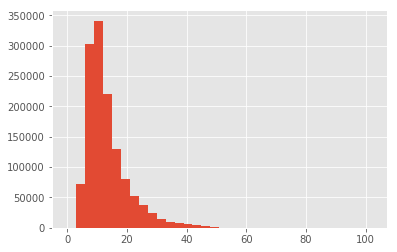

In [15]:
num_words_in_questions = [len(question.split()) for question in dl.train_df['question_text']]
plt.hist(num_words_in_questions,bins = np.arange(0,103,3))
plt.show()

max_text_len = 40 # according to the histogram below

#### 2.3  Load embeddings

In [16]:
embedding_file_name = 'data/embeddings/glove.840B.300d/glove.840B.300d.txt'
emb = Embeddings()
emb.load(embedding_file_name)
print('Embedding loaded')

2196017it [02:37, 13913.36it/s]

Embedding loaded


#### 2.4 Prepare train/validation sets

In [17]:
from sklearn.model_selection import train_test_split

val_size = 0.03
train_df, val_df, _, _ = train_test_split(dl.train_df, dl.train_df['target'], 
                                          test_size=val_size, 
                                          stratify=dl.train_df['target'],
                                          shuffle=True, random_state=seed)
val_X = emb.sequences_to_vec(val_df["question_text"], max_text_len)
val_y = val_df['target'].values

## 3. Neural Network

In [18]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### 3.1 Define NNet

In [19]:
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True),
                        input_shape=(max_text_len, 300)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#### 3.2 Train NNet

In [20]:
batch_size = 128
mg = batch_gen(train_df, batch_size, emb, max_text_len)
model.fit_generator(mg, epochs=20,
                    steps_per_epoch=1000,
                    validation_data=(val_X, val_y),
                    verbose=True)

Epoch 1/20
1000/1000 [==============================] - 186s 186ms/step - loss: 0.1347 - acc: 0.9494 - val_loss: 0.1187 - val_acc: 0.9531
Epoch 2/20
1000/1000 [==============================] - 176s 176ms/step - loss: 0.1190 - acc: 0.9533 - val_loss: 0.1141 - val_acc: 0.9543
Epoch 3/20
1000/1000 [==============================] - 176s 176ms/step - loss: 0.1142 - acc: 0.9554 - val_loss: 0.1120 - val_acc: 0.9553
Epoch 4/20
1000/1000 [==============================] - 179s 179ms/step - loss: 0.1136 - acc: 0.9556 - val_loss: 0.1132 - val_acc: 0.9547
Epoch 5/20
1000/1000 [==============================] - 175s 175ms/step - loss: 0.1102 - acc: 0.9566 - val_loss: 0.1076 - val_acc: 0.9574
Epoch 6/20
1000/1000 [==============================] - 174s 174ms/step - loss: 0.1103 - acc: 0.9561 - val_loss: 0.1083 - val_acc: 0.9563
Epoch 7/20
1000/1000 [==============================] - 174s 174ms/step - loss: 0.1064 - acc: 0.9575 - val_loss: 0.1069 - val_acc: 0.9577
Epoch 8/20
1000/1000 [============

#### 3.3 Plot Learning curves

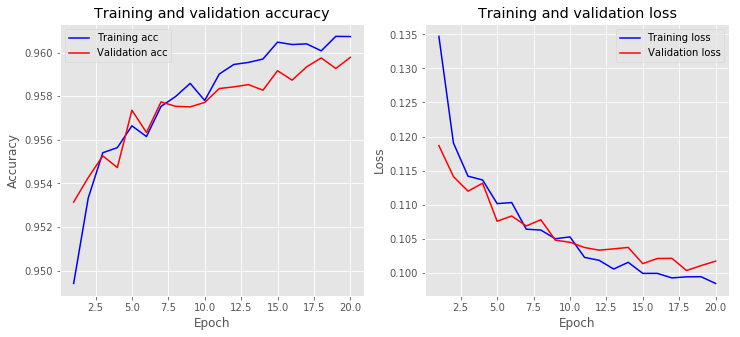

In [21]:
plot_history(model.history)

## 4. Prediction and Submission

#### 4.1 Search for an optimal classification threshold on validation set

In [22]:
from sklearn import metrics
predicted_val_prob = model.predict(val_X).flatten()
 
best_thr, best_f1 = 0., 0.    
for clf_thr in np.arange(0.1, 0.501, 0.01):
    clf_thr = np.round(clf_thr, 2)
    predicted_val_bin = (np.array(predicted_val_prob) > clf_thr).astype(np.int)
    f1_val = metrics.f1_score(val_y, predicted_val_bin)
    if best_f1 <= f1_val:
        best_f1, best_thr = f1_val, clf_thr
    print('F1 score at threshold {} is {:1.3f}'.format(clf_thr, f1_val))
print('Best classification threshold on validation set is {}, F1 is {:1.3f}'.format(best_thr, best_f1))

F1 score at threshold 0.1 is 0.596
F1 score at threshold 0.11 is 0.607
F1 score at threshold 0.12 is 0.615
F1 score at threshold 0.13 is 0.624
F1 score at threshold 0.14 is 0.629
F1 score at threshold 0.15 is 0.637
F1 score at threshold 0.16 is 0.642
F1 score at threshold 0.17 is 0.646
F1 score at threshold 0.18 is 0.650
F1 score at threshold 0.19 is 0.656
F1 score at threshold 0.2 is 0.660
F1 score at threshold 0.21 is 0.663
F1 score at threshold 0.22 is 0.667
F1 score at threshold 0.23 is 0.669
F1 score at threshold 0.24 is 0.670
F1 score at threshold 0.25 is 0.671
F1 score at threshold 0.26 is 0.671
F1 score at threshold 0.27 is 0.672
F1 score at threshold 0.28 is 0.673
F1 score at threshold 0.29 is 0.673
F1 score at threshold 0.3 is 0.672
F1 score at threshold 0.31 is 0.670
F1 score at threshold 0.32 is 0.669
F1 score at threshold 0.33 is 0.667
F1 score at threshold 0.34 is 0.666
F1 score at threshold 0.35 is 0.664
F1 score at threshold 0.36 is 0.662
F1 score at threshold 0.37 is 0

#### 4. 2 Prediction

In [23]:
# predict probabilities
all_preds_prob = []
batch_size_test = 256
for x in tqdm(batch_gen_test(dl.test_df, emb, batch_size_test, max_text_len)):
    all_preds_prob.extend(model.predict(x).flatten())
    
all_preds_prob_bin = (np.array(all_preds_prob) > best_thr).astype(np.int)

441it [00:45,  9.63it/s]


#### 4. 3 Submission

In [24]:
submit_df = pd.DataFrame({"qid": dl.test_df["qid"], "prediction": all_preds_prob_bin})
submit_df.to_csv("submission.csv", index=False)